In [1]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import time
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import scipy
plt.ioff()


seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))





## Running linear regression to get sensetive directions 

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_







unprotected_directions = utils.projection_matrix(sensetive_directions)
protected_directions = np.identity(39) - unprotected_directions



# Casing to tensor 
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')
x_unprotected_train, x_unprotected_test = tf.cast(x_unprotected_train, dtype = tf.float32), tf.cast(x_unprotected_test, dtype = tf.float32)
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)
unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)
protected_directions = tf.cast(protected_directions, dtype = tf.float32)

init_graph = utils.ClassifierGraph(50, 2)
graph = cl.Classifier(init_graph, x_unprotected_train, y_train, x_unprotected_test, y_test, num_steps = 10000) # use for unfair algo
#graph = cl.Classifier(init_graph, tf.matmul(x_unprotected_train, unprotected_directions), 
#                        y_train, tf.matmul(x_unprotected_test, unprotected_directions), y_test, num_steps = 10000) # for fair algo


In [2]:
num_steps, learning_rate = 100, 1e-3
x, y = x_unprotected_test[1], y_test[1]
x = tf.reshape(x, (1, -1))
y = tf.reshape(y, (1, -1))
x_start = x
x = x + tf.cast(np.random.nor)
for _ in range(num_steps):
    with tf.GradientTape() as g:
        g.watch(x)
        prob = graph(x)
        #prob = graph(tf.matmul(x, unprotected_directions))
        loss = utils.EntropyLoss(y, prob)

    gradient = g.gradient(loss, x)
    x = x + learning_rate * tf.matmul(gradient, protected_directions)


In [4]:
x

<tf.Tensor: shape=(1, 39), dtype=float32, numpy=
array([[ 2.6533392e-01, -4.3666583e-01, -1.4775421e-01, -2.1962807e-01,
        -7.7750988e-02, -1.6928021e-02, -1.5180545e-02, -1.8974962e-02,
         9.7575372e-01, -2.3053713e-02, -1.7137798e-02, -2.1871617e-02,
        -2.2519259e-02, -1.8565245e-02,  9.7972530e-01, -2.1704879e-02,
        -2.5267135e-02, -1.6877122e-02, -1.2184309e-02,  5.9662857e-03,
        -3.2492440e-02, -2.0311510e-02,  9.9241918e-01, -2.0599620e-02,
        -2.2240939e-02, -9.5532322e-03,  1.0643863e-04,  1.7797017e-02,
        -5.0067287e-03, -1.4038100e-02, -5.7904567e-03, -5.4158401e-03,
        -1.8232634e-02,  9.4151223e-01, -2.7182851e-02, -2.2569226e-02,
        -2.7207756e-02, -5.2475617e-03,  3.3025681e-03]], dtype=float32)>

In [5]:
x_start

<tf.Tensor: shape=(1, 39), dtype=float32, numpy=
array([[ 0.26477048, -0.43578398, -0.14741328, -0.219069  , -0.0756966 ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)>

In [6]:
tf.matmul(x-x_start, unprotected_directions)

<tf.Tensor: shape=(1, 39), dtype=float32, numpy=
array([[-0.00047439,  0.00052511,  0.00014341,  0.00030511,  0.00090139,
         0.01022093,  0.01117729,  0.01390483,  0.01681653,  0.0164854 ,
         0.01206862,  0.01585362,  0.01668185,  0.01412187,  0.01342954,
         0.01323625,  0.0161708 ,  0.01078461,  0.01210259, -0.00054525,
         0.02112096,  0.01201916,  0.00643077,  0.01257659,  0.01193   ,
         0.00546239,  0.00099759, -0.00709223,  0.00499307,  0.00803421,
         0.0054733 ,  0.00489773,  0.01022929,  0.03442483,  0.01854291,
         0.01393437,  0.01841727,  0.0057424 ,  0.00546579]],
      dtype=float32)>

In [7]:
utils.EntropyLoss(y, graph(tf.matmul(x, unprotected_directions)))\
         - utils.EntropyLoss(y, graph(tf.matmul(x_start, unprotected_directions)))


<tf.Tensor: shape=(), dtype=float32, numpy=0.022236705>

In [3]:
utils.EntropyLoss(y, graph(x))\
         - utils.EntropyLoss(y, graph(x_start))

<tf.Tensor: shape=(), dtype=float32, numpy=0.05385244>

In [1]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import time
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import scipy
plt.ioff()


seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))





## Running linear regression to get sensetive directions 

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_


In [2]:
b = utils.projection_matrix(sensetive_directions)

In [3]:
b

array([[ 9.99927967e-01,  5.20569551e-05,  3.50683480e-06, ...,
         2.22462808e-03,  1.04065524e-03,  1.88042245e-03],
       [ 5.20569551e-05,  9.99913778e-01, -3.46283221e-05, ...,
        -2.61187692e-03, -4.55880783e-04,  4.85363903e-04],
       [ 3.50683480e-06, -3.46283221e-05,  9.99978636e-01, ...,
        -7.71409892e-04,  1.44918132e-04,  1.12633364e-03],
       ...,
       [ 2.22462808e-03, -2.61187692e-03, -7.71409892e-04, ...,
         9.10548166e-01, -2.60194494e-02, -1.99678076e-02],
       [ 1.04065524e-03, -4.55880783e-04,  1.44918132e-04, ...,
        -2.60194494e-02,  9.83160854e-01, -3.84054606e-02],
       [ 1.88042245e-03,  4.85363903e-04,  1.12633364e-03, ...,
        -1.99678076e-02, -3.84054606e-02,  8.80925268e-01]])

In [6]:
b = scipy.linalg.orth(sensetive_directions.T).T
b.shape

(2, 39)

In [7]:
b @ b.T

array([[ 1.00000000e+00, -7.09672319e-17],
       [-7.09672319e-17,  1.00000000e+00]])

In [24]:
b = a/np.linalg.norm(a)

In [25]:
b

array([-0.00836832,  0.00488469, -0.00036053,  0.00204784, -0.00079   ,
        0.09906782,  0.16485571,  0.20355781,  0.22418049,  0.23188209,
        0.16533417,  0.22806128,  0.24837347,  0.21871065,  0.16354753,
        0.13197801,  0.18244202,  0.12123263,  0.25065505,  0.08061395,
        0.24693284,  0.10962203,  0.11441047,  0.12580005,  0.07351997,
        0.04435442,  0.03950541,  0.03391   ,  0.10375105,  0.06545838,
        0.10860299,  0.09320736,  0.07725045,  0.30867674,  0.23958481,
        0.14369608,  0.23441425,  0.12798304,  0.26258444])

In [26]:
np.linalg.norm(b)

0.9999999999999999

In [27]:
b = b/np.linalg.norm(b)

In [28]:
np.linalg.norm(b)

1.0

In [10]:
import scipy
a = np.array([[1,1], [0, 1], [1, 2]])
b = scipy.linalg.orth(a)

In [11]:
b

array([[-0.49079864,  0.65252078],
       [-0.31970025, -0.75130448],
       [-0.81049889, -0.0987837 ]])

In [12]:
b @ b.T

array([[ 0.66666667, -0.33333333,  0.33333333],
       [-0.33333333,  0.66666667,  0.33333333],
       [ 0.33333333,  0.33333333,  0.66666667]])

In [4]:
a = np.array([1,2])
b = np.array([1, 2])

In [5]:
a * b

array([1, 4])

In [3]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import time
import multiprocessing as mp
import random
import matplotlib.pyplot as plt
import scipy
plt.ioff()


seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)
dataset_orig_train, dataset_orig_test = preprocess_adult_data(seed = seed)

x_unprotected_train, x_protected_train = dataset_orig_train.features[:, :39], dataset_orig_train.features[:, 39:]
x_unprotected_test, x_protected_test = dataset_orig_test.features[:, :39], dataset_orig_test.features[:, 39:]
y_train, y_test = dataset_orig_train.labels.reshape((-1,)), dataset_orig_test.labels.reshape((-1,))





## Running linear regression to get sensetive directions 

protected_regression = linear_model.LinearRegression(fit_intercept = False)
protected_regression.fit(x_unprotected_train, x_protected_train)
sensetive_directions = protected_regression.coef_







unprotected_directions = utils.projection_matrix(sensetive_directions)



# Casing to tensor 
y_train, y_test = y_train.astype('int32'), y_test.astype('int32')
x_unprotected_train, x_unprotected_test = tf.cast(x_unprotected_train, dtype = tf.float32), tf.cast(x_unprotected_test, dtype = tf.float32)
y_train, y_test = tf.one_hot(y_train, 2), tf.one_hot(y_test, 2)
unprotected_directions = tf.cast(unprotected_directions, dtype = tf.float32)

init_graph = utils.ClassifierGraph(50, 2)
#graph = cl.Classifier(init_graph, x_unprotected_train, y_train, x_unprotected_test, y_test, num_steps = 10000) # use for unfair algo
graph = cl.Classifier(init_graph, tf.matmul(x_unprotected_train, unprotected_directions), 
                        y_train, tf.matmul(x_unprotected_test, unprotected_directions), y_test, num_steps = 1000) # for fair algo



def sample_perturbation(data_point, regularizer = 1e0, learning_rate = 1e-3, num_steps = 200):
    x, y = data_point
    x = tf.reshape(x, (1, -1))
    y = tf.reshape(y, (1, -1))
    x_start = x
    x += tf.cast(np.random.normal(size=(1, 39)), dtype = tf.float32)*0.01
    for _ in range(num_steps):
        with tf.GradientTape() as g:
            g.watch(x)
            prob = graph(tf.matmul(x, unprotected_directions))
            perturb = tf.matmul(x-x_start, unprotected_directions)
            loss = utils.EntropyLoss(y, prob) - regularizer * tf.norm(perturb)

        gradient = g.gradient(loss, x)
        x = x + learning_rate * gradient#(gradient - tf.matmul(gradient, unprotected_directions)) 

    return_loss = utils.EntropyLoss(y, graph(tf.matmul(x, unprotected_directions)))\
         / utils.EntropyLoss(y, graph(tf.matmul(x_start, unprotected_directions)))
    print(utils.EntropyLoss(y, graph(tf.matmul(x, unprotected_directions))))
    print(utils.EntropyLoss(y, graph(tf.matmul(x_start, unprotected_directions))))
    print('\n')
    return return_loss.numpy()




cpus = mp.cpu_count()
print(f'Number of cpus : {cpus}')
start_time = time.time()
with mp.Pool(cpus) as pool:
    perturbed_test_samples = pool.map(sample_perturbation, zip(x_unprotected_test[:100], y_test[:100]))

Done step 200

Done step 400

Done step 600

Done step 800

Done step 1000

Number of cpus : 8
tf.Tensor(0.37473524, shape=(), dtype=float32)
tf.Tensor(0.42292336, shape=(), dtype=float32)
tf.Tensor(0.016219977, shape=(), dtype=float32)
tf.Tensor(0.34939256, shape=(), dtype=float32)
tf.Tensor(0.016232336, shape=(), dtype=float32)

tf.Tensor(0.16323954, shape=(), dtype=float32)
tf.Tensor(0.08077664, shape=(), dtype=float32)



tf.Tensor(0.16310607, shape=(), dtype=float32)
tf.Tensor(0.080757186, shape=(), dtype=float32)
tf.Tensor(0.33559015, shape=(), dtype=float32)
tf.Tensor(0.25272432, shape=(), dtype=float32)


tf.Tensor(0.14820515, shape=(), dtype=float32)
tf.Tensor(0.42170504, shape=(), dtype=float32)
tf.Tensor(0.25243744, shape=(), dtype=float32)

tf.Tensor(0.33444792, shape=(), dtype=float32)

tf.Tensor(0.14779566, shape=(), dtype=float32)








tf.Tensor(0.975594, shape=(), dtype=float32)
tf.Tensor(0.7549021, shape=(), dtype=float32)
tf.Tensor(0.061525576, shape=(), dtype=floa

In [4]:
perturbed_test_samples

[0.9992386,
 1.292345,
 1.0013875,
 1.0769341,
 1.0008183,
 0.99977446,
 1.0001159,
 1.000533,
 1.0725335,
 1.0009185,
 1.0008193,
 0.9991837,
 1.0011364,
 1.0016645,
 0.9991573,
 1.0001441,
 1.0034152,
 1.0009995,
 1.0008512,
 1.0068774,
 1.0027707,
 1.000452,
 0.99932116,
 1.0002843,
 1.002889,
 1.0006577,
 1.144843,
 1.000058,
 1.0002409,
 1.1859982,
 1.0005351,
 1.0004395,
 1.0001731,
 0.99893373,
 1.002137,
 1.149006,
 1.0000838,
 1.0018108,
 1.0024227,
 1.002375,
 1.2791133,
 0.9999727,
 0.9997523,
 1.1494726,
 1.2341094,
 1.2151718,
 1.0000876,
 0.9999644,
 0.99936247,
 1.1607348,
 1.1412635,
 1.1141483,
 1.0002685,
 1.0007367,
 1.0012852,
 1.3581247,
 1.0005708,
 1.0001227,
 1.000411,
 1.0003575,
 1.335342,
 1.0002056,
 1.1475842,
 1.0004075,
 1.000861,
 1.0811772,
 1.0009152,
 1.0004693,
 1.0002437,
 1.0321598,
 1.0005695,
 1.0008203,
 1.0347952,
 0.9998444,
 1.1200042,
 1.2645013,
 1.0005033,
 1.0004612,
 0.9999555,
 0.9987458,
 1.0000066,
 1.1066773,
 1.0005559,
 0.99976516,

In [5]:
plt.hist(perturbed_test_samples)

(array([76.,  1.,  3.,  5.,  6.,  1.,  2.,  2.,  2.,  2.]),
 array([0.9987458, 1.0346837, 1.0706216, 1.1065595, 1.1424974, 1.1784353,
        1.2143731, 1.250311 , 1.2862489, 1.3221868, 1.3581247],
       dtype=float32),
 <a list of 10 Patch objects>)

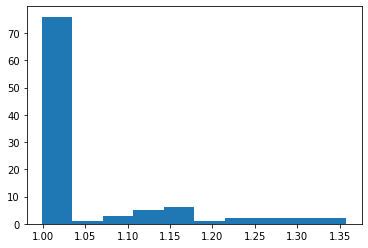

In [6]:
plt.show()

In [4]:
import numpy as np
import tensorflow as tf
from adult_modified import preprocess_adult_data
from sklearn import linear_model
import classifier as cl
import utils
import random
import matplotlib.pyplot as plt
import scipy


seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)


expt = '_1'
filename = f'outcome/perturbed_loss{expt}.npy'
histplot = f'adversarial-points/perturbed-mean-entropy-hist{expt}.png'
qqplot = f'adversarial-points/perturbed-mean-entropy-qqplot{expt}.png'


test_ratio =  np.load(filename)




def ratio_mean(n = 9045):
    index = random.sample(range(n), 1000)
    srswr_ratio=[test_ratio[i] for i in index]
    return np.mean(srswr_ratio)

ratio_means = [ratio_mean() for _ in range(1000)]
plt.hist(ratio_means)
plt.title(f'Histogram of mean loss of ratios for expt{expt}')
plt.xticks(rotation = 35, fontsize = 'x-small')

ValueError: autodetected range of [nan, nan] is not finite

In [ ]:
test_ratio

(array([6.618e+03, 1.224e+03, 5.610e+02, 2.840e+02, 1.800e+02, 7.700e+01,
        4.400e+01, 1.100e+01, 0.000e+00, 1.000e+00]),
 array([ 0.97892475, 10.713427  , 20.44793   , 30.18243   , 39.91693   ,
        49.651436  , 59.385937  , 69.12044   , 78.85494   , 88.58944   ,
        98.323944  ], dtype=float32),
 <a list of 10 Patch objects>)

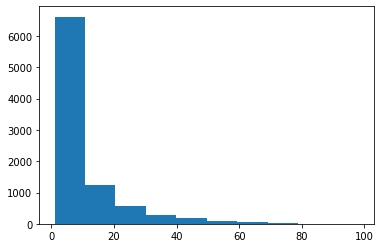

In [6]:
plt.hist(test_ratio)

In [7]:
expt = '_1_fair'
filename = f'outcome/perturbed_loss{expt}.npy'
histplot = f'adversarial-points/perturbed-mean-entropy-hist{expt}.png'
qqplot = f'adversarial-points/perturbed-mean-entropy-qqplot{expt}.png'


test_ratio =  np.load(filename)




def ratio_mean(n = 9045):
    index = random.sample(range(n), 4000)
    srswr_ratio=[test_ratio[i] for i in index]
    return np.mean(srswr_ratio)

ratio_means = [ratio_mean() for _ in range(1000)]
plt.hist(ratio_means)
plt.title(f'Histogram of mean loss of ratios for expt{expt}')
plt.xticks(rotation = 35, fontsize = 'x-small')

ValueError: autodetected range of [nan, nan] is not finite